In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
import ipywidgets as widgets

In [2]:
%%html
<style>
table {align:left;display:block}
</style>

<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>

In [3]:
df = pd.read_csv('MatchStats6Year.csv')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.insert(0, 'Season', df['Date'].dt.year)

In [5]:
# Limit to 2019 Season
df2019 = df[df['Season'] == 2019].copy()

# normalize Aces and PTS per set
df2019['Aces/S'] = df2019['Aces']/df2019['S']
df2019['PTS/S'] = df2019['PTS']/df2019['S']
df2019['Digs/S'] = df2019['Digs']/df2019['S']
df2019['RErr/S'] = df2019['RErr']/df2019['S']
df2019['Kill%'] = df2019['Kills']/df2019['Total Attacks'] * 100.0
df2019['Attack Error%'] = df2019['Errors']/df2019['Total Attacks'] * 100.0

In [6]:
def p3fit(hit_pct):
    x = np.arange(hit_pct.size)
    f = np.poly1d(np.polyfit(x, hit_pct.values, 3))
    return f(x)

In [7]:
pablo = pd.read_csv('PabloRankings.csv')

In [8]:
df2019 = df2019.merge(pablo, how='left', left_on='Team', right_on='NCAA')
df2019 = df2019.drop(columns=['Pablo', 'NCAA'])
df2019 = df2019.rename(columns={'Rank' : 'Team Rank', 'Points' : 'Team Points'})

df2019 = df2019.merge(pablo, how='left', left_on='Opponent', right_on='NCAA')
df2019 = df2019.drop(columns=['Pablo', 'NCAA'])
df2019 = df2019.rename(columns={'Rank' : 'Opp Rank', 'Points' : 'Opp Points'})

df2019['Point Diff'] = df2019['Team Points'] - df2019['Opp Points']

In [9]:
# remove rows with non D1 opponents
df2019 = df2019[~df2019['Opp Rank'].isnull()]

# remove rows missing stats
df2019 = df2019[df2019['Total Attacks'] > 0]

In [10]:
df2019['Point Diff Bin'] = pd.cut(df2019['Point Diff'], bins=np.arange(-3000, 3000, 500))

# How Much Does An Opponent Change a Team's Performance?
### by Steve Aronson

If we look at a teams performance metrics over a season, we will see quite a bit of variation (see Figure 1 below). Intutively, we attribute some of this variation to the strength of the opponent, but can we quantify this effect? That is the goal of this post.

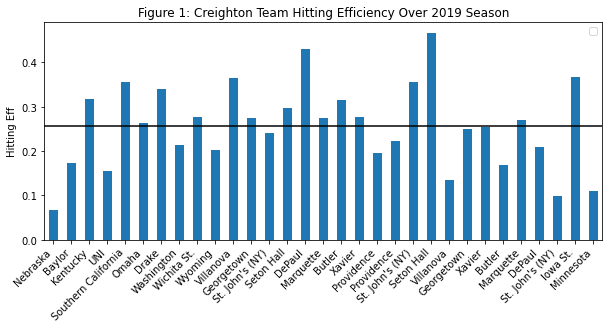

In [11]:
team_name = 'Creighton'
team = df2019[df2019['Team'] == 'Creighton']
# ax = stanford.plot(y=['Hit Pct'], style='o', figsize=(10,4))
ax = team.plot(y=['Hit Pct'], kind='bar', figsize=(10,4))
ax.axes.set_title('Figure 1: ' + team_name + ' Team Hitting Efficiency Over 2019 Season')
# ax.axes.set_xticks(team.index.values)
ax.axes.set_xticklabels(team['Opponent'].values, rotation=45, ha='right')
ax.axes.set_ylabel('Hitting Eff')
ax.legend('')
_ = ax.axhline(team['Hit Pct'].mean(), color='black')

## Assigning opponent strength
I am going to use the Pablo Ratings for the NCAA Women's D1 2019 Season. The Pablo system uses match results to asigns points to each team. Team points are accumulated through the season. The Pablo Rankings are determined by these accumulated points. For Opponent strength, I will be using the Pablo points, but I will compare a team's points to its opponents by taking the difference:

$ PointDiff_{team, match} = Point_{team} - Point_{opponent}$ 

With this definition, the PointDiff is > 0 when you are rated higher (stronger) than your competitions and visa versa. Creighton's PointDiff for the 2019 season is shown in Figure 2. Since most of the values are > 0, Creighton was primarily playing lower ranking teams.

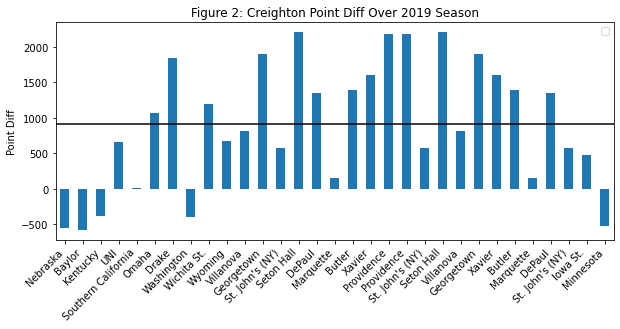

In [12]:
ax = team.plot(y=['Point Diff'], kind='bar', figsize=(10,4))
ax.axes.set_title('Figure 2: ' + team_name + ' Point Diff Over 2019 Season')
#ax.axes.set_xticks(team.index.values)
ax.axes.set_xticklabels(team['Opponent'].values, rotation=45, ha='right')
ax.axes.set_ylabel('Point Diff')
ax.legend('')
_ = ax.axhline(team['Point Diff'].mean(), color='black')

## How Well Does PointDiff Correlate to Performance?
Now that we have a metric that represents opponent relative strength, let's see what performance metrics correlate. With this data set, we will look at:
1. Match Kill%
2. Match Attack Error%
3. Match Hitting Efficiency
4. Aces Per Set
5. Earned Points Per Set (PTS/S)
6. Receive Errors Per Set (RErr/S)

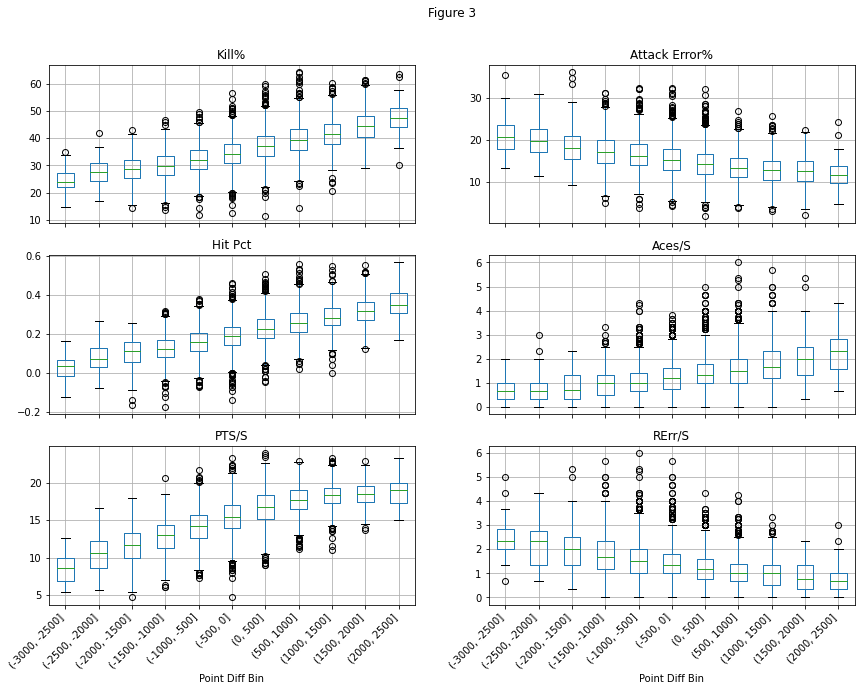

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(14,10), sharey=False)
df2019.boxplot('Kill%', by='Point Diff Bin', ax=ax[0,0])
ax[0,0].set_xlabel('')
ax[0,0].axes.set_xticklabels('')

df2019.boxplot('Attack Error%', by='Point Diff Bin', ax=ax[0,1])
ax[0,1].set_xlabel('')
ax[0,1].axes.set_xticklabels('')

df2019.boxplot('Hit Pct', by='Point Diff Bin', ax=ax[1,0])
ax[1,0].set_xlabel('')
ax[1,0].axes.set_xticklabels('')

df2019.boxplot('Aces/S', by='Point Diff Bin', ax=ax[1,1])
ax[1,1].set_xlabel('')
ax[1,1].axes.set_xticklabels('')

df2019.boxplot('PTS/S', by='Point Diff Bin', ax=ax[2,0])
df2019.boxplot('RErr/S', by='Point Diff Bin', ax=ax[2,1])

ax[2,0].axes.set_xticklabels(ax[1,0].axes.get_xticklabels(), rotation=45, ha='right')
ax[2,1].axes.set_xticklabels(ax[1,1].axes.get_xticklabels(), rotation=45, ha='right')

_ = fig.suptitle('Figure 3')

Performance definitely improves (increase in Kills, Efficiency, Aces, and PTS and decreases in errors) as PointDiff increases. Lets build a regresion model for each metric and evaluate the fits. I will make a few assumptions for this model:
1. Each team has an intrinsic (average) performance for each metric
    1. These mean values will be calculated and subtracted out before running the regression
2. All teams have the same relative response to opponent strength
    1. Each metric will have one set of regression coefficients for all teams
    2. This improves the confidence in regression by using all the data
2. Fit each metric seperately, but using the same model structure
    1. Use a second order fit to capture the curvature seen in some of the plots in Figure 3
    2. Future work will include seperate fits for each team to look at teamt to team variations

## Model Explanation
Using hitting efficiency (HE), the regression model looks like:

$ HE_{team,i} = HE_{team} + he_1 * PointDiff_{team,i} + he_2 * PointDiff_{team,i}^2 + \epsilon_{team,i} $

| Parameter | Description |
|-----------|-------------|
| $HE_{team,i}$ | team hitting efficiency for match i |
| $HE_{base}$ | team inherent hitting efficiency (average) |
| $he_1, he_2$ | model coefficients to fit |
| $PointDiff_{team,i}$ | Difference in rating between team and opponent for match i |
| $\epsilon_{team,i}$ | variability of team for match i |

A similar equation will be used for the other metrics, replacing $HE$ and $he$ with appropriate variables

In [14]:
# create normalize point diff and point diff^2 features
df2019['PD'] = df2019['Point Diff']/7000.0
df2019['PD2'] = df2019['PD'] ** 2

# caluclate and remove team mean from each stat
df2019['Kill% Mean'] = df2019.groupby('Team')['Kill%'].transform('mean')
df2019['Kill% Demean'] = df2019['Kill%'] - df2019['Kill% Mean']

df2019['Attack Error% Mean'] = df2019.groupby('Team')['Attack Error%'].transform('mean')
df2019['Attack Error% Demean'] = df2019['Attack Error%'] - df2019['Attack Error% Mean']

df2019['Hit Pct Mean'] = df2019.groupby('Team')['Hit Pct'].transform('mean')
df2019['Hit Pct Demean'] = df2019['Hit Pct'] - df2019['Hit Pct Mean']

df2019['Aces/S Mean'] = df2019.groupby('Team')['Aces/S'].transform('mean')
df2019['Aces/S Demean'] = df2019['Aces/S'] - df2019['Aces/S Mean']

df2019['PTS/S Mean'] = df2019.groupby('Team')['PTS/S'].transform('mean')
df2019['PTS/S Demean'] = df2019['PTS/S'] - df2019['PTS/S Mean']

df2019['RErr/S Mean'] = df2019.groupby('Team')['RErr/S'].transform('mean')
df2019['RErr/S Demean'] = df2019['RErr/S'] - df2019['RErr/S Mean']

In [15]:
# Run the regressions
kill_reg = LinearRegression().fit(df2019.loc[:, ['PD', 'PD2']].values, df2019['Kill% Demean'])
aerr_reg = LinearRegression().fit(df2019.loc[:, ['PD', 'PD2']].values, df2019['Attack Error% Demean'])
hit_pct_reg = LinearRegression().fit(df2019.loc[:, ['PD', 'PD2']].values, df2019['Hit Pct Demean'])
aces_reg = LinearRegression().fit(df2019.loc[:, ['PD', 'PD2']].values, df2019['Aces/S Demean'])
pts_reg = LinearRegression().fit(df2019.loc[:, ['PD', 'PD2']].values, df2019['PTS/S Demean'])
rerr_reg = LinearRegression().fit(df2019.loc[:, ['PD', 'PD2']].values, df2019['RErr/S Demean'])

In [16]:
# calculate the regression predictions and residuals
df2019['Kill% Opp'] = kill_reg.predict(df2019.loc[:, ['PD', 'PD2']]) + df2019['Kill% Mean']
df2019['Attack Error% Opp'] = aerr_reg.predict(df2019.loc[:, ['PD', 'PD2']]) + df2019['Attack Error% Mean']
df2019['Hit Pct Opp'] = hit_pct_reg.predict(df2019.loc[:, ['PD', 'PD2']]) + df2019['Hit Pct Mean']
df2019['Aces/S Opp'] = aces_reg.predict(df2019.loc[:, ['PD', 'PD2']]) + df2019['Aces/S Mean']
df2019['PTS/S Opp'] = pts_reg.predict(df2019.loc[:, ['PD', 'PD2']]) + df2019['PTS/S Mean']
df2019['RErr/S Opp'] = rerr_reg.predict(df2019.loc[:, ['PD', 'PD2']]) + df2019['RErr/S Mean']

df2019['Kill% Res'] = df2019['Kill%'] - df2019['Kill% Opp']
df2019['Attack Error% Res'] = df2019['Attack Error%'] - df2019['Attack Error% Opp']
df2019['Hit Pct Res'] = df2019['Hit Pct'] - df2019['Hit Pct Opp']
df2019['Aces/S Res'] = df2019['Aces/S'] - df2019['Aces/S Opp']
df2019['PTS/S Res'] = df2019['PTS/S'] - df2019['PTS/S Opp']
df2019['RErr/S Res'] = df2019['RErr/S'] - df2019['RErr/S Opp']

In [17]:
rpd_plot = ((np.arange(-3000, 2500, 500) + 250)).reshape(-1,1)
rpd = np.concatenate((rpd_plot/7000.0, (rpd_plot/7000.0)**2), axis=1)

## Regression results
Lets see how are regressions represent the data. In Figure 4, each plots contains:
1. Individual metrics with the mean removed (subtracted)
2. Regression fit curves
3. Coefficient of determination ($R^2$)

The $R^2$ values tell us how much performance variation can be attributed to $PointDiff$

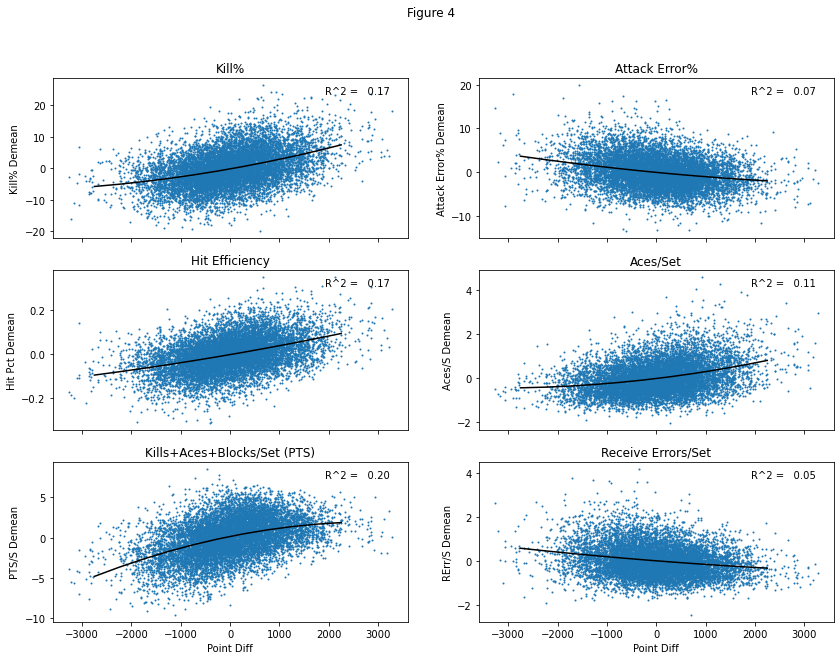

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(14,10), sharey=False)

df2019.plot.scatter('Point Diff', 'Kill% Demean', s=1, ax=ax[0,0])
ax[0,0].plot(rpd_plot, kill_reg.predict(rpd), color='black')
ax[0,0].text(0.95, 0.95, 'R^2 = %6.2f' % kill_reg.score(df2019.loc[:, ['PD', 'PD2']].values, df2019['Kill% Demean']),
            ha='right', va='top', transform=ax[0,0].transAxes)
ax[0,0].set_xlabel('')
ax[0,0].axes.set_xticklabels('')
ax[0,0].set_title('Kill%')

df2019.plot.scatter('Point Diff', 'Attack Error% Demean', s=1, ax=ax[0,1])
ax[0,1].plot(rpd_plot, aerr_reg.predict(rpd), color='black')
ax[0,1].text(0.95, 0.95, 'R^2 = %6.2f' % aerr_reg.score(df2019.loc[:, ['PD', 'PD2']].values, df2019['Attack Error% Demean']),
             ha='right', va='top', transform=ax[0,1].transAxes)
ax[0,1].set_xlabel('')
ax[0,1].axes.set_xticklabels('')
ax[0,1].set_title('Attack Error%')

df2019.plot.scatter('Point Diff', 'Hit Pct Demean', s=1, ax=ax[1,0])
ax[1,0].plot(rpd_plot, hit_pct_reg.predict(rpd), color='black')
ax[1,0].text(0.95, 0.95, 'R^2 = %6.2f' % hit_pct_reg.score(df2019.loc[:, ['PD', 'PD2']].values, df2019['Hit Pct Demean']),
            ha='right', va='top', transform=ax[1,0].transAxes)
ax[1,0].set_xlabel('')
ax[1,0].axes.set_xticklabels('')
ax[1,0].set_title('Hit Efficiency')

df2019.plot.scatter('Point Diff', 'Aces/S Demean', s=1, ax=ax[1,1])
ax[1,1].plot(rpd_plot, aces_reg.predict(rpd), color='black')
ax[1,1].text(0.95, 0.95, 'R^2 = %6.2f' % aces_reg.score(df2019.loc[:, ['PD', 'PD2']].values, df2019['Aces/S Demean']),
            ha='right', va='top', transform=ax[1,1].transAxes)
ax[1,1].set_xlabel('')
ax[1,1].axes.set_xticklabels('')
ax[1,1].set_title('Aces/Set')

df2019.plot.scatter('Point Diff', 'PTS/S Demean', s=1, ax=ax[2,0])
ax[2,0].plot(rpd_plot, pts_reg.predict(rpd), color='black')
ax[2,0].text(0.95, 0.95, 'R^2 = %6.2f' % pts_reg.score(df2019.loc[:, ['PD', 'PD2']].values, df2019['PTS/S Demean']),
            ha='right', va='top', transform=ax[2,0].transAxes)
ax[2,0].set_title('Kills+Aces+Blocks/Set (PTS)')

df2019.plot.scatter('Point Diff', 'RErr/S Demean', s=1, ax=ax[2,1])
ax[2,1].plot(rpd_plot, rerr_reg.predict(rpd), color='black')
ax[2,1].text(0.95, 0.95, 'R^2 = %6.2f' % rerr_reg.score(df2019.loc[:, ['PD', 'PD2']].values, df2019['RErr/S Demean']),
            ha='right', va='top', transform=ax[2,1].transAxes)
ax[2,1].set_title('Receive Errors/Set')

_ = fig.suptitle('Figure 4')

The fits look reasonable, but the $R^2$s are small (5%- 20% of total variation). Opponent strength accounts for some variation, but not the majority.

## What can we do with these correlations?

Looking at an individual team across a season, we can account for some of the performance variation due to the opponent's strength. The remaining variation we will attribute to yourself. By comparing the variances (I will use standard deviations) of these 2 components, we get a sense of which contribution has greater impact.

Reminder of our hitting efficiency model:
$ HE_{team,i} = HE_{team} + he_1 * PointDiff_{team,i} + he_2 * PointDiff_{team,i}^2 + \epsilon_{team,i} $

Let's break this out into three components
1. Base - this is your team's average performance = $HE_{team}$
2. Opp - contribution due to your opponent = $he_1 * PointDiff_{team,i} + he_2 * PointDiff_{team,i}^2$
3. Team - your team's varation = $\epsilon_{team,i}$

For each match, we can calculate these 3 components and plot this over a season. Then we calculate the standard deviation of each component to weigh it's importance.

Note: Standard deviations do not add linearly but by sum of squares:
$\sigma_{hit pct} = \sqrt{\sigma_{opp}^2 + \sigma_{team}^2}$

In [19]:
team_list = df2019['Team'].unique().squeeze()
team_sel = widgets.Dropdown(options=team_list, value='Creighton')
team_sel

Dropdown(index=60, options=('A&M-Corpus Christi', 'Abilene Christian', 'Air Force', 'Akron', 'Alabama', 'Alaba…

## Team Season Residual Plot
Continuing to use Creighton as an example, recall the season hitting efficiency plot. In addition to plotting match hitting efficiencies (blue circles) and the team average (black line), I will add residuals (difference between each point and the average). This residual is split into two parts:
1. Opponent contribution (purple arrows) - portion that the model predicts based on the opponent strength
2. Team contribution (green arrows) - remaining portion that is attributed to factors within your team

On the right are histograms and statistics (means and standard deviations) for:
1. Actuals
2. Opponent contribution
3. Team contribution

Looking at the standard deviations, the opponent contribution is still a small portion of total variation

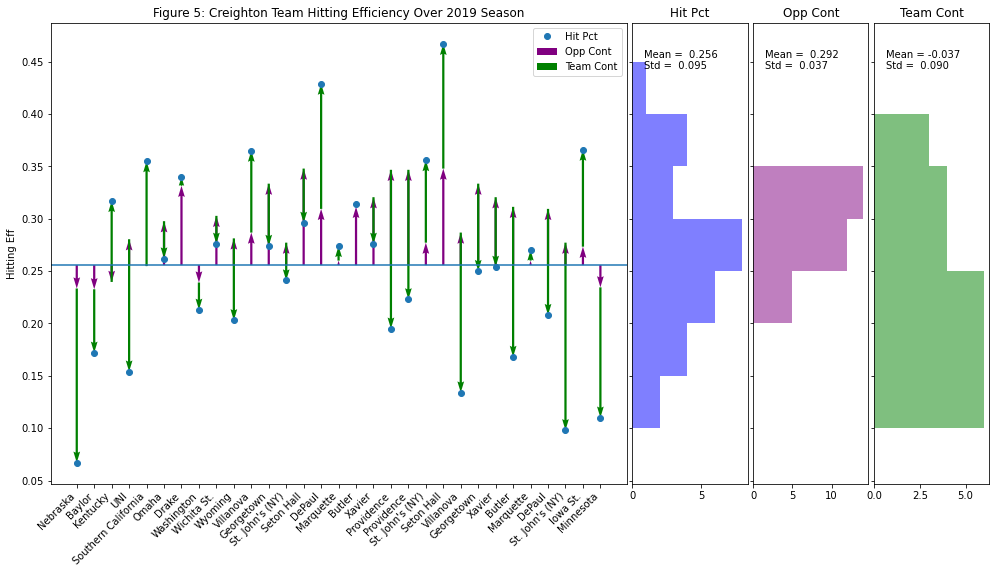

In [20]:
team_name = team_sel.value
team = df2019[df2019['Team'] == team_name]

# start with a square Figure
fig = plt.figure(figsize=(16, 8))

ax_quiver = fig.add_axes([0.1, 0.1, 0.5, 0.8])
ax_hist_1 = fig.add_axes([0.605, 0.1, 0.1, 0.8], sharey=ax_quiver)
ax_hist_2 = fig.add_axes([0.710, 0.1, 0.1, 0.8], sharey=ax_quiver)
ax_hist_3 = fig.add_axes([0.815, 0.1, 0.1, 0.8], sharey=ax_quiver)

team.plot(y=['Hit Pct'], style='o', ax=ax_quiver)
ax_quiver.quiver(team.index.values,
           team['Hit Pct Mean'],
           np.zeros(team.index.values.size),
           team['Hit Pct Opp'].values - team['Hit Pct Mean'],
           units='xy',
           scale=1,
           scale_units='xy',
           width=0.1,
           color='purple')

ax_quiver.quiver(team.index.values,
           team['Hit Pct Opp'].values,
           np.zeros(team.index.values.size),
           team['Hit Pct Res'].values,
           units='xy',
           scale=1,
           scale_units='xy',
           width=0.1,
           color='green')


ax_quiver.axes.set_title('Figure 5: ' + team_name + ' Team Hitting Efficiency Over 2019 Season')
ax_quiver.axes.set_xticks(team.index.values)
ax_quiver.axes.set_xticklabels(team['Opponent'].values, rotation=45, ha='right')
ax_quiver.axes.set_ylabel('Hitting Eff')

ax_quiver.axes.legend(['Hit Pct', 'Opp Cont', 'Team Cont'])
ax_quiver.axhline(team['Hit Pct Mean'].mean())

bins = np.arange(0.1, 0.5, 0.05)
ax_hist_1.hist(team['Hit Pct'], bins=bins, color='blue', orientation='horizontal', alpha=0.5)
ax_hist_1.tick_params(axis='y', labelleft=False)
ax_hist_1.set_title('Hit Pct')
ax_hist_1.text(0.1, 0.9, 'Mean = %6.3f\nStd = %6.3f' % (team['Hit Pct'].mean(), team['Hit Pct'].std()), transform=ax_hist_1.transAxes)

ax_hist_2.hist(team['Hit Pct Opp'], bins=bins, color='purple', orientation='horizontal', alpha=0.5)
ax_hist_2.tick_params(axis='y', labelleft=False)
ax_hist_2.set_title('Opp Cont')
ax_hist_2.text(0.1, 0.9, 'Mean = %6.3f\nStd = %6.3f' % (team['Hit Pct Opp'].mean(), team['Hit Pct Opp'].std()), transform=ax_hist_2.transAxes)

ax_hist_3.hist(team['Hit Pct Res'] + team['Hit Pct Mean'], bins=bins, color='green', orientation='horizontal', alpha=0.5)
ax_hist_3.tick_params(axis='y', labelleft=False)
ax_hist_3.set_title('Team Cont')
_ = ax_hist_3.text(0.1, 0.9, 'Mean = %6.3f\nStd = %6.3f' % (team['Hit Pct Res'].mean(), team['Hit Pct Res'].std()), transform=ax_hist_3.transAxes)

## Distribution of Variances Across All Teams
Now we have a method to seperate the contributions and calcualte the standard deviations of each factor, let's plot the standard deviations for all teams and see how team vs. opponent variations compare. We will do this for all of the statistics.

Each histogram in the plot below contains team level standard deviations - from the team average  - calculated as above. I keep the same color scheme where:
1. Blue is standard deviation of the acutal metric.
2. Purple is standard deviation of the opponent contribution (per the regression model).
3. Green is the standard deviation of the remaining contribution which is labeled team contribution.

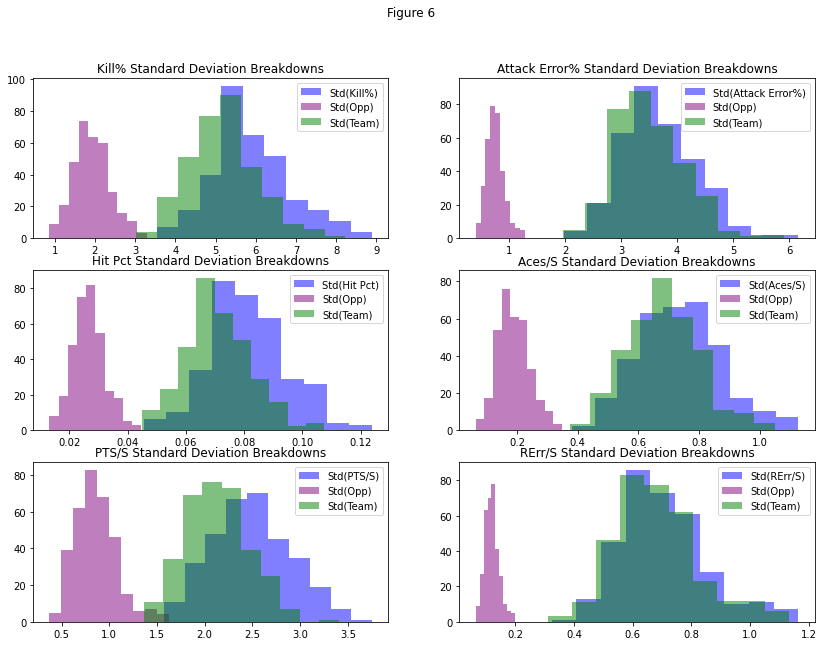

In [21]:
team_hit_stats = df2019.groupby('Team').agg({
    'Kill%': ['mean', 'std'], 
    'Kill% Opp':['mean', 'std'], 
    'Kill% Res':['mean', 'std'],
    'Attack Error%': ['mean', 'std'], 
    'Attack Error% Opp':['mean', 'std'], 
    'Attack Error% Res':['mean', 'std'],
    'Hit Pct': ['mean', 'std'], 
    'Hit Pct Opp':['mean', 'std'], 
    'Hit Pct Res':['mean', 'std'],
    'Aces/S': ['mean', 'std'], 
    'Aces/S Opp':['mean', 'std'], 
    'Aces/S Res':['mean', 'std'],
    'PTS/S': ['mean', 'std'], 
    'PTS/S Opp':['mean', 'std'], 
    'PTS/S Res':['mean', 'std'],
    'RErr/S': ['mean', 'std'], 
    'RErr/S Opp':['mean', 'std'], 
    'RErr/S Res':['mean', 'std'],
})

fig, ax = plt.subplots(3, 2, figsize=(14,10), sharey=False)

ax[0,0].hist(team_hit_stats[('Kill%','std')].values, color='blue', alpha=0.5)
ax[0,0].hist(team_hit_stats[('Kill% Opp','std')].values, color='purple', alpha=0.5)
ax[0,0].hist(team_hit_stats[('Kill% Res','std')].values, color='green', alpha=0.5)
ax[0,0].legend(['Std(Kill%)', 'Std(Opp)', 'Std(Team)'])
ax[0,0].set_title('Kill% Standard Deviation Breakdowns')

ax[0,1].hist(team_hit_stats[('Attack Error%','std')].values, color='blue', alpha=0.5)
ax[0,1].hist(team_hit_stats[('Attack Error% Opp','std')].values, color='purple', alpha=0.5)
ax[0,1].hist(team_hit_stats[('Attack Error% Res','std')].values, color='green', alpha=0.5)
ax[0,1].legend(['Std(Attack Error%)', 'Std(Opp)', 'Std(Team)'])
ax[0,1].set_title('Attack Error% Standard Deviation Breakdowns')

ax[1,0].hist(team_hit_stats[('Hit Pct','std')].values, color='blue', alpha=0.5)
ax[1,0].hist(team_hit_stats[('Hit Pct Opp','std')].values, color='purple', alpha=0.5)
ax[1,0].hist(team_hit_stats[('Hit Pct Res','std')].values, color='green', alpha=0.5)
ax[1,0].legend(['Std(Hit Pct)', 'Std(Opp)', 'Std(Team)'])
ax[1,0].set_title('Hit Pct Standard Deviation Breakdowns')

ax[1,1].hist(team_hit_stats[('Aces/S','std')].values, color='blue', alpha=0.5)
ax[1,1].hist(team_hit_stats[('Aces/S Opp','std')].values, color='purple', alpha=0.5)
ax[1,1].hist(team_hit_stats[('Aces/S Res','std')].values, color='green', alpha=0.5)
ax[1,1].legend(['Std(Aces/S)', 'Std(Opp)', 'Std(Team)'])
ax[1,1].set_title('Aces/S Standard Deviation Breakdowns')

ax[2,0].hist(team_hit_stats[('PTS/S','std')].values, color='blue', alpha=0.5)
ax[2,0].hist(team_hit_stats[('PTS/S Opp','std')].values, color='purple', alpha=0.5)
ax[2,0].hist(team_hit_stats[('PTS/S Res','std')].values, color='green', alpha=0.5)
ax[2,0].legend(['Std(PTS/S)', 'Std(Opp)', 'Std(Team)'])
ax[2,0].set_title('PTS/S Standard Deviation Breakdowns')

ax[2,1].hist(team_hit_stats[('RErr/S','std')].values, color='blue', alpha=0.5)
ax[2,1].hist(team_hit_stats[('RErr/S Opp','std')].values, color='purple', alpha=0.5)
ax[2,1].hist(team_hit_stats[('RErr/S Res','std')].values, color='green', alpha=0.5)
ax[2,1].legend(['Std(RErr/S)', 'Std(Opp)', 'Std(Team)'])
ax[2,1].set_title('RErr/S Standard Deviation Breakdowns')

_ = fig.suptitle('Figure 6')

# Conclusion
Looking at Figure 6:
1. The opponent strength contribution to team performance (purple histograms) exisits and is measurable
2. Opponent strength only accounts for a small percentage of a teams performance variation. The larger reamining variation (green histograms) comes from internal factors - ones that are not visible on a box score.
3. The opponent effect is most present in Kill%, Hitting Efficiency and Earned Points. 

A viable method to quantify opponent strength impact on a team's performance has been developed. The effect is small (smaller than I expected). This leads into trying to understand what other measureable factors impact performance variation. Can we quantify other factors the allow coaches to help manage the peaks and valleys of their team's performance.